# Trabalho Prático 1
### Matéria: Introdução a Computação Visual
### Alunos: Luís Gustavo Costa da Silva, Matheus Marchesotti Dutra Ferraz
### Matrículas:

 #### *Descrição*
 Abkaskdjkasjdlajflasdj

In [15]:
import numpy
import cv2
import matplotlib.pyplot as plt
from math import log10
import urllib.request

In [2]:
def visualize(image_matrix, title):
    plt.title(title)
    image_plot = plt.imshow(image_matrix)
    plt.colorbar()
    return True

In [3]:
def compress():
    
    return

In [4]:
def decompress():
    
    return

In [ ]:
def psnr(matrix_i, matrix_k):
    m, n = matrix.shape()
    
    mse = 0
    for i in range(m-1):
        for j in range(n-1):
            mse = mse + (matrix_i[i][j] - matrix_k[i][j])**2
            
    mse = mse/(m*n)
    max_number = max(max(matrix_i))
    psne = 10*log10(max_number**2 / mse)
    
    return psne

In [ ]:
def compress_rate(original_image, compressed_image):
    pixels_i, pixels_j = original_image.shape
    compressed_pixels_i, compressed_pixels_j = compressed_image.shape
    
    compress_rate =  (compressed_pixels_i*compressed_pixels_j) / (pixels_i*pixels_j)
    
    return compress_rate

In [33]:
img = cv2.imread('woman-relaxed-work.jpg',0)
img

array([[217, 217, 216, ..., 172, 171, 170],
       [218, 217, 216, ..., 176, 175, 175],
       [218, 218, 217, ..., 174, 174, 175],
       ...,
       [171, 173, 173, ..., 192, 193, 192],
       [174, 172, 173, ..., 191, 192, 192],
       [175, 169, 172, ..., 189, 191, 191]], dtype=uint8)

In [ ]:
visualize(img, "Test image")

In [85]:
def subtract_matrix(image_matrix):
    subtract_128 = lambda i: i - 128
    vectorized_subtract_128 = numpy.vectorize(subtract_128)
    subtracted_image_matrix = vectorized_subtract_128(image_matrix)

    return subtracted_image_matrix

In [86]:
def add_matrix(image_matrix):
    add_128 = lambda i: i + 128
    vectorized_add_128 = numpy.vectorize(add_128)
    added_image_matrix = vectorized_add_128(image_matrix)

    return added_image_matrix

In [52]:
quantization_table_1 = numpy.array([[16, 11, 10, 16, 24, 40, 51, 61], [12, 12, 14, 19, 26, 58, 60, 55], [14, 13, 16, 24, 40, 57, 69, 56], [14, 17, 22, 29, 51, 87, 80, 62], [18, 22, 37, 56, 68, 109, 103, 77], [24, 35, 55, 64, 81, 104, 113, 92], [49, 64, 78, 87, 103, 121, 120, 101], [72, 92, 95, 98, 112, 100, 103, 99]])
quantization_table_2 = numpy.array([[17, 18, 24, 47, 99, 99, 99, 99], [18, 21, 26, 66, 99, 99, 99, 99], [24, 26, 56, 99, 99, 99, 99, 99], [47, 66, 99, 99, 99, 99, 99, 99], [99, 99, 99, 99, 99, 99, 99, 99], [99, 99, 99, 99, 99, 99, 99, 99], [99, 99, 99, 99, 99, 99, 99, 99], [99, 99, 99, 99, 99, 99, 99, 99]])

In [36]:
image_matrix = numpy.array(img)
image_matrix

array([[217, 217, 216, ..., 172, 171, 170],
       [218, 217, 216, ..., 176, 175, 175],
       [218, 218, 217, ..., 174, 174, 175],
       ...,
       [171, 173, 173, ..., 192, 193, 192],
       [174, 172, 173, ..., 191, 192, 192],
       [175, 169, 172, ..., 189, 191, 191]], dtype=uint8)

In [41]:
rows, columns = img.shape
print(rows)
print(columns)
if(rows%8!=0):
    rows -= rows%8-8
if(columns%8!=0):
    columns -= columns%8-8
print(rows)
print(columns)

2973
4460
2976
4464


In [43]:
def add_padding(image_matrix):
    padded = numpy.zeros((rows,columns))
    padded[:image_matrix.shape[0],:image_matrix.shape[1]] = image_matrix
    
    return padded

array([[217., 217., 216., ...,   0.,   0.,   0.],
       [218., 217., 216., ...,   0.,   0.,   0.],
       [218., 218., 217., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [48]:
test = numpy.array([[5., 4, 19, 23, 30, 30, 31, 32],[14, 10, 21, 24, 29 ,26, 26, 24],[25, 21, 34, 33, 31, 24, 24, 23],[34, 28, 29, 30, 29, 29, 30, 29],[31, 32, 35, 33, 32, 26, 25, 24],[37, 34, 34, 32, 34, 28, 26, 30],[32, 36, 35, 32, 33, 30, 24, 26],[33, 32, 38, 36, 39, 34, 29, 28]])

In [88]:
dct = cv2.dct(test)
dct

array([[ 2.26375000e+02, -2.22763027e+00, -1.59813578e+01,
        -1.86002212e+00,  5.37500000e+00,  1.19277160e+00,
         4.86080782e+00,  6.66841638e+00],
       [-3.12764223e+01, -2.77037660e+01, -4.80881428e+00,
        -7.63792654e-01,  1.93151040e+00,  6.05983991e+00,
         1.59681819e+00,  2.62192546e+00],
       [-8.63674883e+00, -1.87633787e+01, -7.63280573e+00,
         8.95674608e-01, -7.83772805e-01, -1.44134596e+00,
         2.19194174e+00,  1.36087726e+00],
       [-4.47625429e+00, -6.67853193e+00,  2.72384805e+00,
        -2.37324524e-01,  4.99916089e-02, -3.32630505e+00,
        -8.31548934e-01, -7.16220918e-01],
       [ 3.37500000e+00, -6.98432974e+00,  2.98619396e-01,
         1.10872516e+00, -1.12500000e+00,  1.21762875e+00,
        -2.58991229e-01, -2.64096283e-01],
       [ 2.12049404e+00, -1.52121595e+00,  3.99463762e+00,
        -1.01431316e-01, -9.20201241e-01, -6.81200024e-01,
         1.93975683e-01, -2.08754168e+00],
       [ 5.60694388e+00,  4.252080

In [58]:
quantization_table_1

array([[ 16,  11,  10,  16,  24,  40,  51,  61],
       [ 12,  12,  14,  19,  26,  58,  60,  55],
       [ 14,  13,  16,  24,  40,  57,  69,  56],
       [ 14,  17,  22,  29,  51,  87,  80,  62],
       [ 18,  22,  37,  56,  68, 109, 103,  77],
       [ 24,  35,  55,  64,  81, 104, 113,  92],
       [ 49,  64,  78,  87, 103, 121, 120, 101],
       [ 72,  92,  95,  98, 112, 100, 103,  99]])

In [77]:
quantized = numpy.divide(dct, quantization_table_1)
quantized = numpy.around(quantized, decimals=0)
quantized

array([[14., -0., -2., -0.,  0.,  0.,  0.,  0.],
       [-3., -2., -0., -0.,  0.,  0.,  0.,  0.],
       [-1., -1., -0.,  0., -0., -0.,  0.,  0.],
       [-0., -0.,  0., -0.,  0., -0., -0., -0.],
       [ 0., -0.,  0.,  0., -0.,  0., -0., -0.],
       [ 0., -0.,  0., -0., -0., -0.,  0., -0.],
       [ 0.,  0., -0., -0.,  0.,  0.,  0.,  0.],
       [-0.,  0., -0., -0., -0., -0.,  0.,  0.]])

In [79]:
dequantized = numpy.multiply(quantized, quantization_table_1)
dequantized

array([[224.,  -0., -20.,  -0.,   0.,   0.,   0.,   0.],
       [-36., -24.,  -0.,  -0.,   0.,   0.,   0.,   0.],
       [-14., -13.,  -0.,   0.,  -0.,  -0.,   0.,   0.],
       [ -0.,  -0.,   0.,  -0.,   0.,  -0.,  -0.,  -0.],
       [  0.,  -0.,   0.,   0.,  -0.,   0.,  -0.,  -0.],
       [  0.,  -0.,   0.,  -0.,  -0.,  -0.,   0.,  -0.],
       [  0.,   0.,  -0.,  -0.,   0.,   0.,   0.,   0.],
       [ -0.,   0.,  -0.,  -0.,  -0.,  -0.,   0.,   0.]])

In [81]:
inverse_dct = cv2.idct(dequantized)
inverse_dct

array([[ 7.4888753 , 10.72930861, 15.88729522, 21.00441277, 24.47207307,
        25.76235629, 25.50838191, 24.92198089],
       [12.38227686, 15.22630972, 19.65184381, 23.81196602, 26.24378203,
        26.57706991, 25.59064301, 24.60784154],
       [20.09551121, 22.32095336, 25.60348086, 28.27019298, 29.08555357,
        27.92543136, 25.79599786, 24.19460569],
       [27.57539447, 29.21525539, 31.41576987, 32.66876385, 31.95392694,
        29.38008659, 26.16864007, 23.98166667],
       [32.35458948, 33.6448899 , 35.19950079, 35.60858107, 33.98029855,
        30.5625445 , 26.70519439, 24.16866049],
       [33.70550712, 34.93548518, 36.37863489, 36.64208411, 34.85617169,
        31.29278658, 27.32397529, 24.72711903],
       [32.75107516, 34.10529074, 35.77800143, 36.34138653, 34.88012236,
        31.61667314, 27.87742283, 25.40480408],
       [31.5155111 , 32.9985851 , 34.90939511, 35.78387197, 34.65933109,
        31.70697362, 28.20582263, 25.86206231]])

In [87]:
decodified = add_matrix(inverse_dct)
decodified = numpy.around(decodified, decimals=0)
decodified

array([[135., 139., 144., 149., 152., 154., 154., 153.],
       [140., 143., 148., 152., 154., 155., 154., 153.],
       [148., 150., 154., 156., 157., 156., 154., 152.],
       [156., 157., 159., 161., 160., 157., 154., 152.],
       [160., 162., 163., 164., 162., 159., 155., 152.],
       [162., 163., 164., 165., 163., 159., 155., 153.],
       [161., 162., 164., 164., 163., 160., 156., 153.],
       [160., 161., 163., 164., 163., 160., 156., 154.]])

In [21]:
# load

array([[217, 217, 216, ..., 172, 171, 170],
       [218, 217, 216, ..., 176, 175, 175],
       [218, 218, 217, ..., 174, 174, 175],
       ...,
       [171, 173, 173, ..., 192, 193, 192],
       [174, 172, 173, ..., 191, 192, 192],
       [175, 169, 172, ..., 189, 191, 191]], dtype=uint8)

True

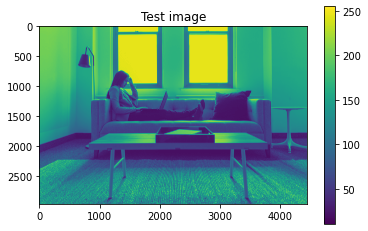

In [22]:
# visualize

In [28]:
# divide

In [26]:
# compress

array([[89, 89, 88, ..., 44, 43, 42],
       [90, 89, 88, ..., 48, 47, 47],
       [90, 90, 89, ..., 46, 46, 47],
       ...,
       [43, 45, 45, ..., 64, 65, 64],
       [46, 44, 45, ..., 63, 64, 64],
       [47, 41, 44, ..., 61, 63, 63]])

In [ ]:
# save

In [ ]:
# visualize

In [ ]:
# decompress

In [ ]:
# visualize

In [ ]:
# psnr and compress rate

In [ ]:
# final comparisson

figure = plt.figure()

ax = figure.add_subplot(1, 3, 1)
image_plot = plt.imshow(original_image)
ax.set_title("Before codification")

ax = figure.add_subplot(1, 3, 3)
image_plot = plt.imshow(decodified_image)
ax.set_title("Decodified image")